In [1]:
import numpy as np
import matplotlib.pyplot as plt
from math import factorial

In [2]:
def couchy(x):
    return 1/(1 + x**2)

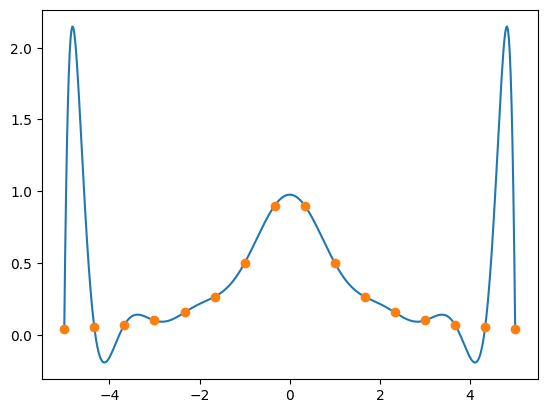

In [11]:
n = 16
x = np.linspace(-5, 5, n)
y = couchy(x)

X = np.linspace(-5, 5, 500)
plt.plot(X, sum([a*X**j for j, a in enumerate((np.linalg.inv(np.vander(x, increasing=True)) @ y))]))
plt.plot(x, y, 'o')

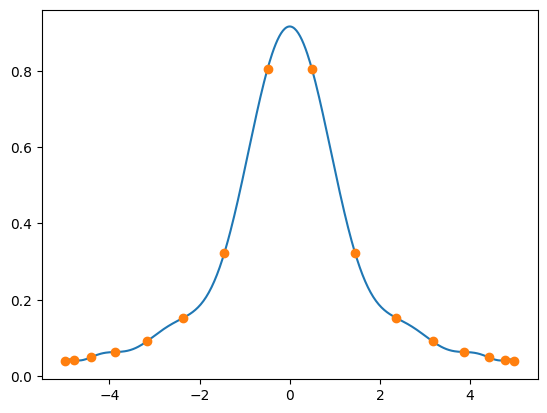

In [12]:
n = 16
x = 5*np.stack([np.cos(np.pi*(2*k - 1)/(2*n)) for k in range(1, n+1)])
y = couchy(x)

X = np.linspace(-5, 5, 500)
plt.plot(X, sum([a*X**j for j, a in enumerate((np.linalg.inv(np.vander(x, increasing=True)) @ y))]))
plt.plot(x, y, 'o')